In [1]:
import numpy as np
import jax.numpy as jnp
from itertools import product
import jax
from typing import NamedTuple, Optional


class MDP(NamedTuple):
    S_set: jnp.array  # state space
    A_set: jnp.array  # action space
    gamma: float  # discount factor
    H: int  # effective horizon
    rew: jnp.array  # reward matrix
    P: jnp.array  # transition matrix
    phi: jnp.array  # feature matrix
    optimal_Q: Optional[jnp.ndarray] = None

    @property
    def S(self) -> int:
        return len(self.S_set)

    @property
    def A(self) -> int:
        return len(self.A_set)

    @property
    def d(self) -> int:
        return self.phi.shape[-1]



@jax.jit
def create_hard_mdp(key, A: int = 30, Delta: float = 0.01, d: int = 4, gamma: float = 0.9):
    """Create the Hard Linear MDP. See Appendix L in the paper.

    Args:
        key: jax.random.PRNGKey
        A (int, optional): Action space size
        Delta (float, optional): Hyper parameter to adjust the difficulty of MDP
        d (int, optional): Feature dimension
        gamma (float, optional): discount factor

    Returns:
        key: jax.random.PRNGKey
        mdp (MDP): created MDP
    """
    S = 2  # size of the state space
    S_set = jnp.arange(S)  # state space
    H = int(1 / (1 - gamma))  # effective horizon

    # create the action set
    key, newkey = jax.random.split(key)
    A_set = jax.random.uniform(newkey, shape=(A, d - 2))
    # assert A == len(A_set)

    # β is the optimal action
    beta_idx = -1 
    beta = A_set[beta_idx]

    # create the feature vector
    phi_s0 = jnp.concatenate((jnp.ones((A, 1)), jnp.zeros((A, 1))), axis=-1)
    phi_s0 = jnp.concatenate((phi_s0, A_set), axis=-1)
    # assert jnp.all(phi_s0[0] == jnp.array([1, 0, *A_set[0]]))
    # assert phi_s0.shape == (A, d)

    phi_s1 = jnp.zeros((A, d))
    phi_s1 = phi_s1.at[:, 1].set(1.0)
    # assert phi_s1.shape == (A, d)

    phi = jnp.concatenate((phi_s0[None, :, :], phi_s1[None, :, :]), axis=0)
    # assert phi.shape == (S, A, d)

    # create the reward function
    theta_r = jnp.zeros(d)
    theta_r = theta_r.at[0].set(1.0)
    rew = phi @ theta_r

    # create the transition function
    psi_s0 = jnp.array([gamma, 0, *(Delta * beta)])
    # assert psi_s0.shape == (d, )
    psi_s1 = jnp.array([1 - gamma, 1, *(-Delta * beta)])
    # assert psi_s1.shape == (d, )

    P_to_s0 = phi @ psi_s0
    P_to_s1 = phi @ psi_s1
    _P = jnp.concatenate((P_to_s0[:, :, None], P_to_s1[:, :, None]), axis=-1)
    # assert _P.shape == (S, A, S)
    _P_normalize = jnp.sum(_P, axis=-1, keepdims=True)
    phi = phi / _P_normalize
    P_to_s0 = phi @ psi_s0
    P_to_s1 = phi @ psi_s1
    P = jnp.concatenate((P_to_s0[:, :, None], P_to_s1[:, :, None]), axis=-1)
    # np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)

    mdp = MDP(S_set, A_set, gamma, H, rew, P, phi)
    return key, mdp


In [2]:
import numpy as np
from functools import partial
import jax.numpy as jnp
import jax
import chex


@partial(jax.jit, static_argnames=("S", "A", "d"))
def compute_optimal_design(S: int, A: int, d: int, mdp: MDP, f: jnp.array, epsilon: float = 0.01):
    """Compute the optimal design by Frank-Wolfe algorithm.
    See Algorithm 7 in the paper.

    Args:
        S (int): state space size.
        A (int): action space size
        d (int): feature dimension
        mdp (MDP)
        f (jnp.array): weighting function
        epsilon (float, optional): optimal design accuracy

    Returns:
        core_set: (S * A) vector with bool values
        u: This is the computed design. (S * A) vector with [0, 1] values.
        Gf: Design matrix. d x d matrix
    """
    # Run Frank-Wolfe algorithm

    m = S * A
    n = d
    assert f.shape == (S, A)
    f = f.reshape(1, m)
    X = mdp.phi.reshape(m, n).T / f
    assert X.shape == (n, m)

    # >>>> initialization >>>>
    u = jnp.ones(m) / m
    XUX = X @ jnp.diag(u) @ X.T
    H = jnp.linalg.inv(XUX)
    # assert not jnp.any(jnp.isnan(H))
    vmap_xHx = jax.vmap(lambda x: x @ H @ x)
    w = vmap_xHx(X.T)
    assert w.shape == (m,)
    # <<<< initialization <<<<

    def one_step_exact_FW(u, w):
        i = w.argmax()
        cur_epsilon = ((w - n) / n)[i]
        w_i = w[i]
        u_i = u[i]

        lam = (w_i - n) / ((n - 1) * w_i)
        lam = jnp.maximum(lam, -u_i)
        u = u.at[i].set(u_i + lam)
        u = u / (1 + lam)

        diag_u = jnp.diag(u)
        XUX = X @ diag_u @ X.T
        H = jnp.linalg.inv(XUX)
        vmap_xHx = jax.vmap(lambda x: x @ H @ x)
        w_updated = vmap_xHx(X.T)
        assert w.shape == (m,)
        return cur_epsilon, u, w_updated


    def cond_fn(args):
        cur_epsilon, u, w = args
        return cur_epsilon > epsilon


    def body_fn(args):
        cur_epsilon, u, w = args
        cur_epsilon, u, w = one_step_exact_FW(u, w)
        return cur_epsilon, u, w


    cur_epsilon = jnp.inf
    cur_epsilon, u, w = jax.lax.while_loop(cond_fn, body_fn, (cur_epsilon, u, w))

    # extract core-set
    delta = cur_epsilon
    thresh = ((delta ** 2) * (n ** 2)) / 4
    thresh = 1 + delta * n / 2 - jnp.sqrt(delta * n - delta + thresh)
    thresh = n * thresh
    core_set = w >= thresh

    # compute Gf
    vmap_dot = jax.vmap(jnp.dot)
    phi = mdp.phi.reshape(-1, d)
    Gf = vmap_dot(phi.reshape(-1, d, 1), phi.reshape(-1, 1, d)) / f.reshape(-1, 1, 1) * u.reshape(-1, 1, 1)
    Gf = (Gf * core_set.reshape(m, 1, 1)).sum(axis=0)

    chex.assert_shape(core_set, (S * A,))
    chex.assert_shape(u, (S * A,))
    chex.assert_shape(Gf, (d, d))
    return core_set, u, Gf


In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


@jax.jit
def compute_greedy_policy(Q: jnp.ndarray):
    """

    Args:
        Q (jnp.ndarray): (SxA) matrix

    Returns:
        greedy_policy (jnp.ndarray): (SxA) matrix
    """
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy


@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):
    """compute the optimal Q function of the MDP
    Args:
        mdp (MDP)

    Returns:
        optimal_Q (jnp.ndarray): (SxA) matrix
    """

    def backup(optimal_Q):
        next_v = mdp.P @ optimal_Q.max(axis=1)
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.H * 10, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """ compute the policy matrix useful for compute_policy_Q
    Args:
        policy (jnp.ndarray): (SxA) matrix

    Returns:
        policy_matrix (jnp.ndarray): (SxSA) matrix
    """
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@jax.jit
def compute_policy_Q(mdp: MDP, policy: jnp.ndarray):
    """compute Q_pi of the mdp
    Args:
        mdp (MDP)
        policy (jnp.ndarray): (SxA) matrix

    Returns:
        optimal_Q (jnp.ndarray): (SxA) matrix
    """
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))

    Pi = compute_policy_matrix(policy)
    PPi = mdp.P.reshape(S*A, S) @ Pi
    policy_Q = jnp.linalg.inv(jnp.eye(S*A) - mdp.gamma * PPi) @ mdp.rew.reshape(S*A)
    return policy_Q.reshape(S, A)



In [4]:
from jax.random import PRNGKey


@partial(jax.jit, static_argnames=("N",))
def sample_next_state(mdp: MDP, N: int, key: PRNGKey, D: jnp.array):
    """ Sample N next states according to the transition matrix P
    Args:
        mdp (MDP)
        N (int): number of next states to sample
        key (PRNGKey)
        D (jnp.ndarray): state-action pairs to sample next states [(s1, a1), (s2, a2), ...]

    Returns:
        new_key (PRNGKey)
        next_s_set (jnp.ndarray): next states of (len(D) x N)
    """

    new_key, key = jax.random.split(key)
    keys = jax.random.split(key, num=len(D))
    @jax.vmap
    def choice(key, sa):
        return jax.random.choice(key, mdp.S_set, shape=(N,), p=mdp.P[sa[0], sa[1]])
    next_s = choice(keys, D)
    return new_key, next_s



In [5]:
import matplotlib.pyplot as plt
from functools import partial

@partial(jax.vmap, in_axes=(None, None, 0, 0))
def compute_target_q(mdp, V, r_sa, next_s):
    next_v = V[next_s].mean()
    target_q = r_sa + mdp.gamma * next_v
    return target_q


def wlsmdvi_G(mdp: MDP, key: PRNGKey, M: int, K: int, core_set: jnp.ndarray, rho: jnp.ndarray, Gf: jnp.ndarray, f: jnp.ndarray):
    """Run WLS-MDVI with G-optimal design. See Algorithm 1 in the paper.

    Args:
        mdp (MDP)
        key (PRNGKey): jax.random.PRNGKey.
        M (int): Number of samples from the generative model
        K (int): Number of iterations
        core_set (jnp.ndarray)
        rho (jnp.ndarray): the computed optimal design
        Gf (jnp.ndarray): the design matrix
        f (jnp.ndarray): weighting function

    Returns:
        key: jax.random.PRNGKey
        V: computed value function
        optimality_gaps: performance of the WLS-MDVI
    """
    Gf_inv = jnp.linalg.inv(Gf)
    SA_set = jnp.array([(s, a) for s, a in product(range(mdp.S), range(mdp.A))])

    rho = rho.reshape(-1, 1)
    phi = mdp.phi.reshape(-1, mdp.d)
    f = f.reshape(-1, 1)
    rew = mdp.rew.reshape(-1, 1)
    core_set = core_set.reshape(-1, 1)

    def body_fn(i, args):
        key, theta, theta_, optimality_gaps = args
        S = mdp.phi @ theta
        S_ = mdp.phi @ theta_
        W = S.max(axis=-1).reshape(-1)
        W_ = S_.max(axis=-1).reshape(-1)
        V = W - mdp.gamma * W_
 
        # evaluate the performance
        greedy_policy = compute_greedy_policy(S)
        pol_V = compute_policy_Q(mdp, greedy_policy).max(axis=-1)
        optimal_V = mdp.optimal_Q.max(axis=-1)
        gap = jnp.abs(optimal_V - pol_V).max() / jnp.abs(optimal_V).max()
        optimality_gaps = optimality_gaps.at[i].set(gap)

        # update the parameter
        key, next_state = sample_next_state(mdp, M, key, SA_set)
        next_state = next_state.reshape(-1, M)
        target = compute_target_q(mdp, V, rew, next_state).reshape(-1, 1)
        y = ((rho * phi * target / (f ** 2)) * core_set).sum(axis=0)
        chex.assert_shape(y, (mdp.d,))
        theta_target = Gf_inv @ y

        theta_ = theta
        theta = theta_target + mdp.gamma * theta
        return key, theta, theta_, optimality_gaps

    theta = np.zeros(mdp.d)
    theta_ = np.zeros(mdp.d)
    optimality_gaps = jnp.zeros(K)
    args = key, theta, theta_, optimality_gaps
    key, theta, theta_, optimality_gaps = jax.lax.fori_loop(0, K, body_fn, args)
    S = mdp.phi @ theta
    S_ = mdp.phi @ theta_
    W = S.max(axis=-1).reshape(-1)
    W_ = S_.max(axis=-1).reshape(-1)
    V = W - mdp.gamma * W_
    return key, V, optimality_gaps


@partial(jax.jit, static_argnames=("M", "K"))
def lsmdvi(mdp: MDP, key: PRNGKey, M: int, K: int):
    """WLS-MDVI with f=1"""
    f = jnp.ones((mdp.S, mdp.A))
    core_set, rho, Gf = compute_optimal_design(mdp.S, mdp.A, mdp.d, mdp, f, 0.01)
    num_samples = jnp.arange(K) * core_set.sum() * M
    key, V, optimality_gaps = wlsmdvi_G(mdp, key, M, K, core_set, rho, Gf, f)
    return key, V, optimality_gaps, num_samples


def variance_estimation(mdp: MDP, key: PRNGKey, M: int, V: jnp.ndarray, core_set: jnp.ndarray, rho: jnp.ndarray, G: jnp.ndarray):
    """Estimate the variance function given the value function V. See Algorithm 2 in the paper.
    Args:
        mdp (MDP)
        key (PRNGKey): jax.random.PRNGKey
        M (int): Number of samples from the generative model
        V (jnp.ndarray): learned value function
        core_set: (S * A) vector with bool values
        rho (jnp.ndarray): the design
        G (jnp.ndarray): Design matrix
 
    Returns:
        key: jax.random.PRNGKey
        var: estimated variance
    """
    @partial(jax.vmap, in_axes=(None, 0, 0))
    def compute_target_var(V, next_s1, next_s2):
        target_var = jnp.mean((V[next_s1] - V[next_s2]) ** 2 / 2)
        return target_var

    SA_set = jnp.array([(s, a) for s, a in product(range(mdp.S), range(mdp.A))])
    key, next_state1 = sample_next_state(mdp, M, key, SA_set)
    key, next_state2 = sample_next_state(mdp, M, key, SA_set)
    target_var = compute_target_var(V, next_state1, next_state2).reshape(-1, 1)

    rho = rho.reshape(-1, 1)
    phi = mdp.phi.reshape(-1, mdp.d)
    core_set = core_set.reshape(-1, 1)

    y = (rho * phi * target_var * core_set).sum(axis=0)
    chex.assert_shape(y, (mdp.d,))
    w = jnp.linalg.inv(G) @ y
    var = mdp.phi @ w
    return key, var


@partial(jax.jit, static_argnames=("M", "K", "M_sigma"))
def vwlsmdvi(mdp: MDP, key: PRNGKey, M: int, K: int, K_pre_ratio: float = 0.2, M_sigma: int = 5000):
    """the VWLS-MDVI algorithm. See Algorithm 3 in the paper."""
    # 1st run of wlsmdvi
    pre_K = int(K * K_pre_ratio)
    f = jnp.ones((mdp.S, mdp.A))
    core_set, rho, Gf = compute_optimal_design(mdp.S, mdp.A, mdp.d, mdp, f, 0.01)
    key, V, pre_optimality_gaps = wlsmdvi_G(mdp, key, M, pre_K, core_set, rho, Gf, f)
    num_samples = jnp.arange(pre_K) * core_set.sum() * M

    # variance estimation
    var_estimation_samples = M_sigma
    key, Var_v = variance_estimation(mdp, key, var_estimation_samples, V, core_set, rho, Gf)
    chex.assert_shape(Var_v, (mdp.S, mdp.A))

    # 2nd run of wlsmdvi
    post_K = int(K * (1 - K_pre_ratio))
    f = jnp.minimum(jnp.sqrt(jnp.maximum(Var_v, 0)) + jnp.sqrt(mdp.H), mdp.H)
    core_set, rho, Gf = compute_optimal_design(mdp.S, mdp.A, mdp.d, mdp, f, 0.01)
    key, V, post_optimality_gaps = wlsmdvi_G(mdp, key, M, post_K, core_set, rho, Gf, f)
    num_samples = jnp.hstack((num_samples, jnp.arange(post_K) * core_set.sum() * M + num_samples[-1] + var_estimation_samples))
    optimality_gaps = jnp.hstack((pre_optimality_gaps, post_optimality_gaps))
    return key, V, optimality_gaps, num_samples


@partial(jax.jit, static_argnames=("M", "K"))
def vwlsmdvi_star(mdp: MDP, key: PRNGKey, M: int, K: int):
    """WLS-MDVI with f ~ sigma*. See Algorithm 1 in the paper."""
    optimal_v = mdp.optimal_Q.max(axis=-1)
    Var_v = mdp.P @ optimal_v ** 2 - (mdp.P @ optimal_v) ** 2
    f = jnp.minimum(jnp.sqrt(jnp.maximum(Var_v, 0)) + jnp.sqrt(mdp.H), mdp.H)
    core_set, rho, Gf = compute_optimal_design(mdp.S, mdp.A, mdp.d, mdp, f, 0.01)
    num_samples = jnp.arange(K) * core_set.sum() * M
    key, V, optimality_gaps = wlsmdvi_G(mdp, key, M, K, core_set, rho, Gf, f)
    return key, V, optimality_gaps, num_samples


In [6]:
import seaborn as sns
import pickle
import pandas as pd
from functools import partial

# plot results
num_mdp = 100

for M, K in zip([100, 1000], [1000, 100]):
    algos = {
        r"WLS-MDVI ($f={\bf 1}$)": lsmdvi,
        r"WLS-MDVI ($f=f_*$)": vwlsmdvi_star,
        r"VWLS-MDVI: $M_\sigma=100000$": partial(vwlsmdvi, M_sigma=100000),
        r"VWLS-MDVI: $M_\sigma=5000$": partial(vwlsmdvi, M_sigma=5000),
    }

    def build_run_algo(algo):

        def run_algo(key, mdp_key):
            def body_fn(i, args):
                key, mdp_key, optimality_gaps_list, num_samples_list = args
                mdp_key, mdp = create_hard_mdp(mdp_key)
                optimal_Q_DP = compute_optimal_Q(mdp)
                mdp = mdp._replace(optimal_Q=optimal_Q_DP)
                key, _, optimality_gaps, num_samples = algo(mdp, key, M, K)
                optimality_gaps_list = optimality_gaps_list.at[i].set(optimality_gaps)
                num_samples_list = num_samples_list.at[i].set(num_samples)
                return key, mdp_key, optimality_gaps_list, num_samples_list

            optimality_gaps_list = jnp.zeros((num_mdp, K))
            num_samples_list = jnp.zeros((num_mdp, K))
            args = key, mdp_key, optimality_gaps_list, num_samples_list
            _, _, optimality_gaps_list, num_samples_list = jax.lax.fori_loop(0, num_mdp, body_fn, args)
            return optimality_gaps_list, num_samples_list
        
        return jax.jit(run_algo)


    key = PRNGKey(0)
    mdp_key = PRNGKey(128)
    results = {}

    for name, algo in algos.items():
        run_algo = build_run_algo(algo)
        optimality_gaps, num_samples = run_algo(key, mdp_key)
        results[name] = optimality_gaps, num_samples

    with open(f"results-{M}-{K}.pkl", "wb") as f:
        pickle.dump(results, f)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
import pickle

with open(f"results-100-1000.pkl", "rb") as f:
    results100 = pickle.load(f)


with open(f"results-1000-100.pkl", "rb") as f:
    results1000 = pickle.load(f)

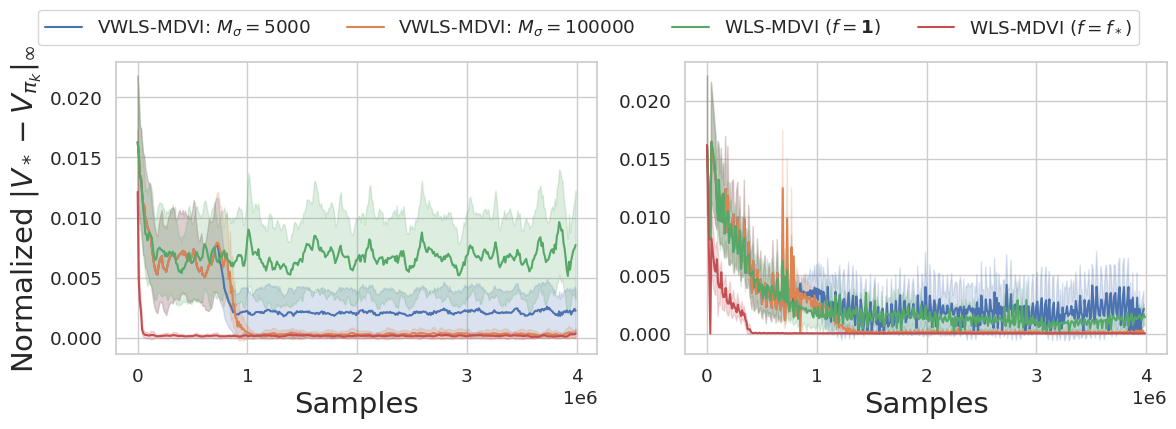

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


algos =  [r"VWLS-MDVI: $M_\sigma=5000$", r"VWLS-MDVI: $M_\sigma=100000$", r"WLS-MDVI ($f={\bf 1}$)", r"WLS-MDVI ($f=f_*$)"]
fig = plt.figure(figsize=(12, 4))
sns.set(font_scale=1.2)
axes = []

with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(121)
    for name in algos:
        gap_sample = results100[name]
        optimality_gaps, num_samples = gap_sample
        # window the results for visibility
        dfs = []
        for gaps, samples in zip(optimality_gaps, num_samples):
            df = pd.DataFrame({"Samples": samples, "Gaps": gaps})
            df["Samples"] = df["Samples"].round(-4)
            df["Gaps"] = df["Gaps"].rolling(10, min_periods=1).mean()
            df = df[df["Samples"] < 4e6]
            dfs.append(df)

        df = pd.concat(dfs)
        sns.lineplot(df, x="Samples", y="Gaps", errorbar=("sd", 0.5), label=name, legend=False, ax=ax)

    ax.set_xlabel("Samples", fontsize=21)
    ax.set_ylabel(r"Normalized $|V_* - V_{\pi_k}|_\infty$", fontsize=21)
    # ax.set_ylim([-0.002, 0.015])
    axes.append(ax)

    ax = fig.add_subplot(122)
    for name in algos:
        gap_sample = results1000[name]
        optimality_gaps, num_samples = gap_sample
        # window the results for visibility
        dfs = []
        for gaps, samples in zip(optimality_gaps, num_samples):
            df = pd.DataFrame({"Samples": samples, "Gaps": gaps})
            df["Samples"] = df["Samples"].round(-4)
            df["Gaps"] = df["Gaps"].rolling(10, min_periods=1).mean()
            df = df[df["Samples"] < 4e6]
            dfs.append(df)

        df = pd.concat(dfs)
        sns.lineplot(df, x="Samples", y="Gaps", errorbar=("sd", 0.5), label=name, legend=False, ax=ax)
    ax.set_xlabel("Samples", fontsize=21)
    ax.get_yaxis().get_label().set_visible(False)
    # ax.set_ylim([-0.002, 0.015])
    axes.append(ax)

    handles = [None] * len(algos)
    for ax in axes:
        handle, label = ax.get_legend_handles_labels()
        for h, name in zip(handle, label):
            handles[algos.index(name)] = h

    lgd = fig.legend(handles, algos, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=len(algos))
    fig.tight_layout()
    plt.savefig(f"VWLS-MDVI.pdf", bbox_extra_artists=(lgd, ), bbox_inches="tight")
    plt.savefig(f"VWLS-MDVI.png", bbox_extra_artists=(lgd, ), bbox_inches="tight")